https://discourse.pymc.io/t/pymc3-sampling-not-taking-place-for-the-entire-range-of-values-between-the-given-bounds-of-a-uniform-prior/729

In [1]:
%pylab inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_ = pd.read_table('aaa.txt',header=None).values

In [3]:
gamma=3.77
G = 4.302*10**-6
rmin = 3.0
R = 95.7

vr = data_[:, 1]
r = data_[:, 0]

with pm.Model() as basic_model:
    M = pm.Uniform('M', lower=0.5, upper=32.6)
    beta = pm.Uniform('beta',lower=2.001,upper=2.9)
    q = gamma/(beta - 2) - 3/2
    B = (G*M*10**12)/((beta-2)*(R**(3 - beta)))
    K = (gamma - 3)/((rmin**(3 - gamma))*((2*B)**0.5))
    logp = -tt.log(K*((1 -(( 1/(2*B) )*((vr**2)*r**(beta - 2))))**(q+1))*(r**(1-gamma +(beta/2))))
    def logp_func(r, vr):
        return  tt.sum(logp)  
    logpvar = pm.DensityDist("logpvar", logp_func, observed={"r": r, "vr":vr})
    trace = pm.sample(1000, tune=1000, njobs=1, chains=4)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '29591' (I am process '1248')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_interval__, M_interval__]
100%|██████████| 2000/2000 [00:04<00:00, 411.14it/s]


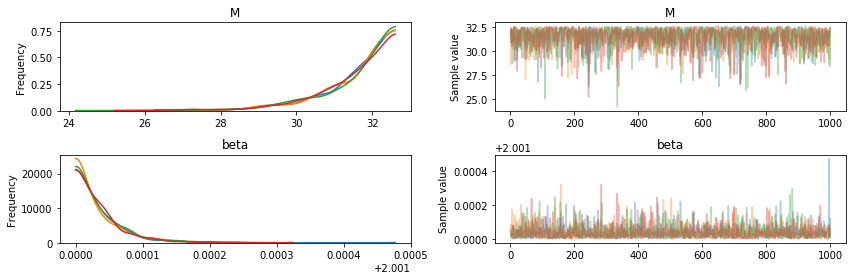

In [4]:
pm.traceplot(trace);

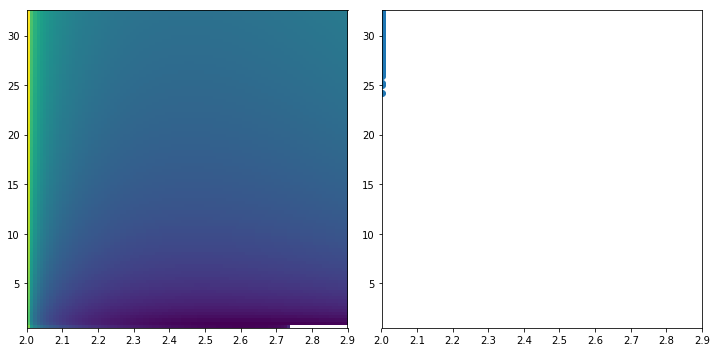

In [5]:
def cust_logp(z):
    M = z[0]
    beta = z[1]
    q = gamma/(beta - 2) - 3/2
    B = (G*M*10**12)/((beta-2)*(R**(3 - beta)))
    K = (gamma - 3)/((rmin**(3 - gamma))*((2*B)**0.5))
    logp = -np.log(K*((1 -(( 1/(2*B) )*((vr**2)*r**(beta - 2))))**(q+1))*(r**(1-gamma +(beta/2))))
    return np.sum(logp)

grid = np.mgrid[32.6:.5:100j, 2.001:2.9:100j]
Z = np.asarray([cust_logp(g) for g in grid.reshape(2, -1).T])
top, left = grid[:, 0, 0]
bottom, right = grid[:, -1, -1]
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Z.reshape(100,100), extent=[left, right, bottom, top], aspect='auto');

ax[1].scatter(trace['beta'], trace['M'])
ax[1].set_xlim([2.001,2.9])
ax[1].set_ylim([.5,32.6])

plt.tight_layout();

In [6]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
M,31.530833,1.032156,1.978438e-02,29.427561,32.599543,2553.0,1.000242
beta,2.001037,0.000039,7.922676e-07,2.001000,2.001114,2556.0,0.999657


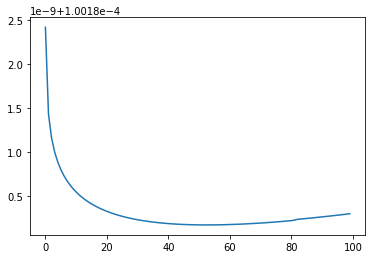

In [7]:
Znorm = np.exp(Z/np.nansum(Z))
Znorm /= np.nansum(Znorm)
plt.plot(np.nanmean(Znorm.reshape(100,100), axis=0));

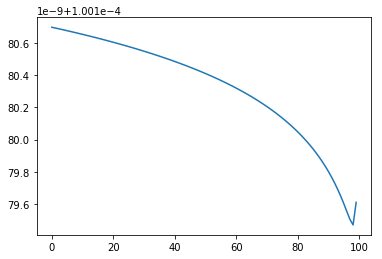

In [8]:
plt.plot(np.nanmean(Znorm.reshape(100,100), axis=1));

In [ ]:
import theano
from scipy.integrate import quad
theano.config.compute_test_value = 'off'

class Integrate(theano.Op):
    def __init__(self, expr, var, *extra_vars):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = extra_vars
        self._func = theano.function(
            [var] + list(extra_vars),
            self._expr,
            on_unused_input='ignore')
    
    def make_node(self, start, stop, *extra_vars):
        self._extra_vars_node = extra_vars
        assert len(self._extra_vars) == len(extra_vars)
        self._start = start
        self._stop = stop
        vars = [start, stop] + list(extra_vars)
        return theano.Apply(self, vars, [tt.dscalar().type()])
    
    def perform(self, node, inputs, out):
        start, stop, *args = inputs
        val = quad(self._func, start, stop, args=tuple(args))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        start, stop, *args = inputs
        out, = grads
        replace = dict(zip(self._extra_vars, args))
        
        replace_ = replace.copy()
        replace_[self._var] = start
        dstart = out * theano.clone(-self._expr, replace=replace_)
        
        replace_ = replace.copy()
        replace_[self._var] = stop
        dstop = out * theano.clone(self._expr, replace=replace_)

        grads = tt.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self._extra_vars)
            darg = out * integrate(start, stop, *args)
            dargs.append(darg)
            
        return [dstart, dstop] + dargs

    
## Basic usage

# We define the function we want to integrate
x = tt.dscalar('x')
x.tag.test_value = np.zeros(())
a = tt.dscalar('a')
a.tag.test_value = np.ones(())

func = a ** 2 * x**2
integrate = Integrate(func, x, a)

In [16]:
# Check gradients
from theano.tests.unittest_tools import verify_grad
verify_grad(integrate, (np.array(0.), np.array(1.), np.array(2.)))
verify_grad(integrate, (np.array(-2.), np.array(5.), np.array(8.)))

In [17]:
# Now, we define values for the integral
start = tt.dscalar('start')
start.tag.test_value = np.zeros(())
stop = tt.dscalar('stop')
stop.tag.test_value = np.ones(())
a_ = tt.dscalar('a_')
a_.tag.test_value = np.ones(())

# Note, that a_ != a
val = integrate(start, stop, a_)

# Evaluate the integral and derivatives
val.eval({start: 0., stop: 1., a_: 2.})

array(1.3333333333333335)

In [18]:
tt.grad(val, a_).eval({start: -2, stop: 1, a_: 2.})

array(12.0)

In [19]:
tt.grad(val, start).eval({start: 1., stop: 2., a_: 2.})

array(-4.0)

In [22]:
import pymc3 as pm

## Usage in PyMC3
with pm.Model() as model:
    start = pm.Normal('start', -5, 1)
    stop = pm.Normal('stop', 5, 1)
    a = pm.Normal('a', 0.5, 1)
    
    # Define the function to integrate in plain theano
    x = tt.dscalar('x_')
    x.tag.test_value = np.zeros(())
    a_ = tt.dscalar('a_')
    a_.tag.test_value = np.ones(())

    func = a_ ** 2 * x**2
    integrate = Integrate(func, x, a_)

    # Now we plug in the values from the model.
    # The `a_` from above corresponds to the `a` here.
    val = integrate(start, stop, a)
    pm.Normal('y', mu=val, sd=1, observed=10)
    mtrace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, stop, start]
100%|██████████| 1000/1000 [00:43<00:00, 23.02it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [40]:
start = theano.shared(-(np.pi)/2)
stop = theano.shared((np.pi)/2)

with pm.Model() as basic_model:
    M = pm.Uniform('M', lower=10**8, upper=10**13)
    beta = pm.Uniform('beta', lower=2.001, upper=2.999, testval=2.5)
    
    # set up the integration function
    x = tt.dscalar('x')
    x.tag.test_value = np.zeros(())
    beta_ = tt.dscalar('beta_')
    beta_.tag.test_value = np.ones(())*2.5
    z1 = tt.cos(x)**(2*((gamma/(beta_ - 2)) - 3/2) + 3)
    integrate = Integrate(z1, x, beta_)
    integ_val = integrate(start, stop, beta)
    # integ = tt.printing.Print('integ')(integ_val)
    
    # define the logp
    def logp_func(rn, vn):
        q = (gamma/(beta - 2)) - 3/2
        B = (G*M) / ((beta -2 )*(R**(3 - beta)))
        K = (gamma - 3) / ((rmin**(3 - gamma)) * (2*B)**0.5) * integ_val
        logp = - tt.log(K*((1 -((1/(2*B))*((vn**2)*rn**(beta - 
                                           2))))**(q+1))*(rn**(1-gamma +(beta/2))))
        return tt.sum(logp)
    
    logpvar = pm.DensityDist("logpvar", logp_func, observed={"rn": r, "vn":vr})
    trace = pm.sample()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_interval__, M_interval__]
INFO:pymc3:NUTS: [beta_interval__, M_interval__]
100%|██████████| 1000/1000 [03:19<00:00,  7.65it/s]
